# A look at music charts: The effect on artist exposure/performance

## Notebook by [Jeff Sontag](https://github.com/jmoso13)


# Introduction

Musicians rely heavily on online music charts for exposure and validation. Fans rely on these same charts to make finding good music easy and reliable. But how does performance on a popular music chart exactly translate to exposure for an artist and can fans really rely on algorithms to find the most compelling new music? As both a musician and lover of new music I set out to look at one of the most dominant music charts, [Hype Machine](https://hypem.com), and see what performance on this chart means for listeners and artists. 

Data was collected multiple times every day starting Jan 1, 2017. The Hype Machine Top 50 chart was scraped for artist[s], track title, rank, and links to Spotify, SoundCloud, and Apple Music. After organizing and cleaning all unique tracks into a single dataset, I was able to calculate a track's peak rank on the chart, the number of days it charted, and whether or not a track dropped off the chart to then re-emerge later.

After calculating these basic statistics the tracks' SoundCloud links were used to collect information on their current SoundCloud plays, reposts, likes, and number of followers an artist had. Tracks that were not available on SoundCloud were excluded from this dataset, leaving 1205 tracks that had charted between January and March 2017.


# Step 1: Defining the goal

For this analysis, much of what I hope to accomplish will be exploratory. What sorts of associations can we find among tracks that perform well on SoundCloud vs. those that perform well on Hype Machine? Are these the same tracks? These sorts of questions are important to listeners who likely hope that tracks performing well on Hype Machine really are the best of the best.

To accomplish this goal, I will hope to define in some sense what a "successful" track looks like on SoundCloud. Is this a track that receives a lot of plays? A track that receives a lot of likes/reposts? Or a combination of these statistics?

Once SoundCloud "success" is more or less defined, relationships between a track's peak rank on Hype Machine and SoundCloud success will be explored. Finally I'll turn to modelling techniques to see if it is possile to predict SoundCloud success based on a track's peak position on the Hype Machine chart.

As a bonus, I also hope to see if we can segment the data using unsupervised learning techniques. These techniques allow the computer to look at data and cluster it into interpretable groups. This may give us a sense of the type of artists that are showing up on Hype Machine and how they are performing.


# Step 2: Probing the Data

I'll be using Python 3.4 and the following libraries to explore the data (following descriptions taken from [RHiever](https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb) along with other inspiration):

1. **NumPy**: Provides a fast numerical array structure and helper functions.
2. **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
3. **scikit-learn**: The essential Machine Learning package in Python.
4. **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
5. **Seaborn**: Advanced statistical plotting library.

Let's start by importing the libraries we'll be using.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from datetime import datetime
import math

%matplotlib inline

Now let's import the dataset. NA values were represented as -1's and empty cells.

.head() allows us to see the first 5 observations, checking that everything looks good.

In [2]:
hype_m = pd.read_csv("april_sc_join_init.csv", na_values = ['', '-1'])
hype_m.head()

,Unnamed: 0,Artist,Bandcamp Link,DateTime,Other Links,Rank,Remix Artist,Soundcloud Link,Spotify Link,Track ID,...,First Date Seen,Days On Chart,Number of Re-Emergences,SC Like to Play Ratio,SC Repost to Play Ratio,sc_acct_followers,sc_likes,sc_plays,sc_pull_time,sc_reposts
0,0,Hey Violet,NaN,"02-01-2017 05:02:09 Wed, Feb",NaN,1.0,Prince Fox Remix,https://soundcloud.com/princefoxmusic/gmapfremix,https://open.spotify.com/track/4lgpXc2IafbNTUD...,2kpqe,...,2017-02-01 05:02:09,0 days 03:53:44.000000000,NaN,0.020575,0.004687,66615.0,3982.0,193533.0,04-04-2017 07:14:09,907.0
1,1,Marbert Rocel,NaN,"02-01-2017 05:02:09 Wed, Feb",NaN,2.0,Nico Pusch Bootleg Remix,https://soundcloud.com/sunset-boulevard/marber...,NaN,1m6re,...,2017-02-01 05:02:09,0 days 00:00:00.000000000,NaN,0.011976,0.002585,285.0,366.0,30560.0,04-04-2017 07:14:09,79.0
2,2,Kiiara,NaN,"02-01-2017 05:02:09 Wed, Feb",NaN,3.0,HERO VHS Pop Remix,https://soundcloud.com/yourfriendhero/kiiara-h...,NaN,2kn95,...,2017-02-01 05:02:09,0 days 00:00:00.000000000,NaN,NaN,NaN,NaN,NaN,NaN,04-04-2017 07:14:09,NaN
3,3,Vincent,NaN,"02-01-2017 05:02:09 Wed, Feb",NaN,4.0,NaN,https://soundcloud.com/vincent_official/her,https://open.spotify.com/track/0ePeGyJeURzbmXv...,2fcaq,...,2017-02-01 05:02:09,0 days 14:05:52.000000000,NaN,0.027213,0.005011,101212.0,63404.0,2329928.0,04-04-2017 07:14:09,11676.0
4,4,Aaron Taos,NaN,"02-01-2017 05:02:09 Wed, Feb",NaN,5.0,NaN,https://soundcloud.com/aarontaos/off-my-mind,https://open.spotify.com/track/3MFaRVxcPCa9mbX...,2kn8d,...,2017-02-01 05:02:09,2 days 13:45:26.000000000,1.0,0.004583,0.001052,1849.0,924.0,201602.0,04-04-2017 07:14:09,212.0


So the data appears to be in decent format, there are a lot of columns we don't necessarily need to keep track of so let's subset the data into SoundCloud-specific stats and work with that. 

There's also a bit of tidying that needs to be done with some of the datetime variables. Let's take care of that now.

In [3]:
### Tidying

# Converts to decimal days
hype_m["Days On Chart"] = pd.to_timedelta(hype_m["Days On Chart"])/np.timedelta64(1,'D')

# Change re-emergence NAs to 0
hype_m["Number of Re-Emergences"] = hype_m["Number of Re-Emergences"].fillna(0)

# Change date first seen to datetime
hype_m["First Date Seen"] = pd.to_datetime(hype_m["First Date Seen"]).astype(np.int64)


### Creating New Dataset

# Creating SoundCloud-Specific Dataset
h_sc = hype_m[["SC Like to Play Ratio", "SC Repost to Play Ratio", "sc_acct_followers", 
               "sc_likes", "sc_plays", "sc_reposts", "Peak Rank", "Days On Chart", 
               "Number of Re-Emergences", "First Date Seen", "Track ID"]]

# Dropping NA values
h_sc = h_sc.dropna()

An anticipated worry is that tracks that have been up a less amount of time will naturally skew to less plays and less likes/reposts. In order to keep a mostly homogenous set we'll drop all observations that were recorded after March 20, 2017. This should give tracks included in the dataset a fairly good amount of time to accumulate a good representation of plays etc.

In [4]:
# Getting an epoch time to compare w/
date = [datetime(2017, 3, 20)]
index = pd.DatetimeIndex(date)
epoch_cutoff = pd.to_datetime(index).astype(np.int64)

# Reducing sc data to those observations seen before 2 weeks ago
h_sc = h_sc.loc[h_sc["First Date Seen"] < epoch_cutoff[0]]

Now that the data is sufficiently "tidied" let's get a first look at some of our basic stats.

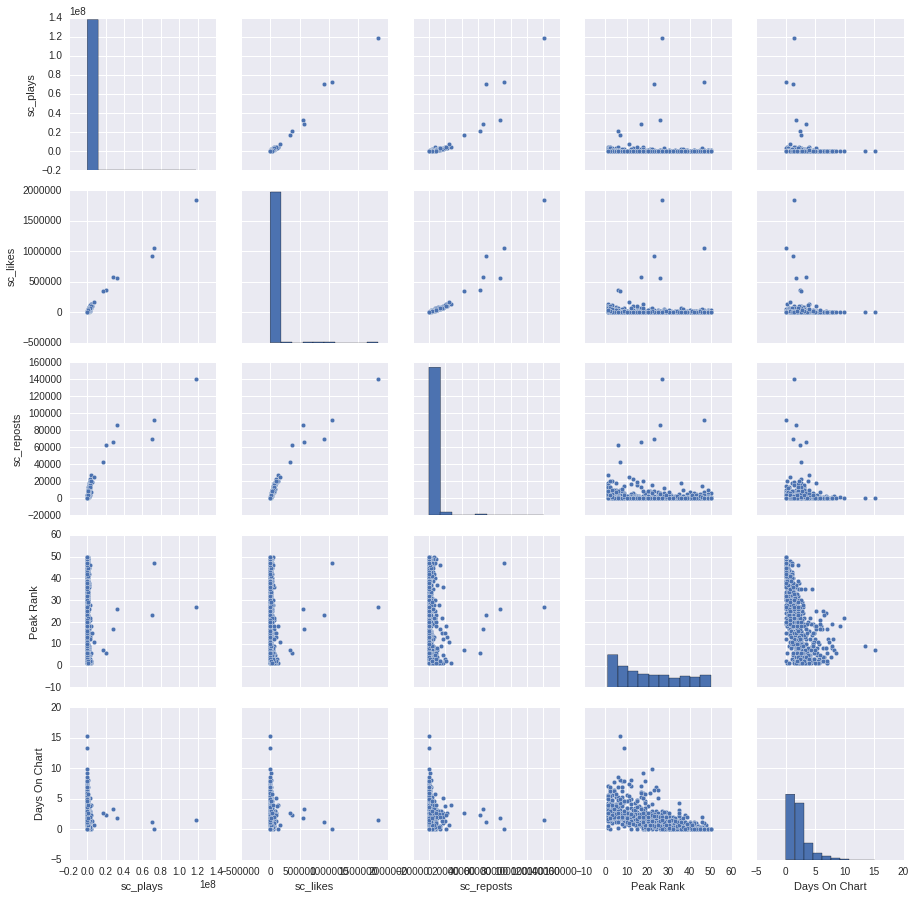

In [5]:
sb.pairplot(h_sc[["sc_plays", "sc_likes", "sc_reposts", "Peak Rank", "Days On Chart"]])

There appear to be a few observations that could be considered outliers. These datapoints have high plays on soundcloud and thus are dwarfing the other observations to the point where we cannot observe relationships very well. I will label them as "viral" and separate them out.

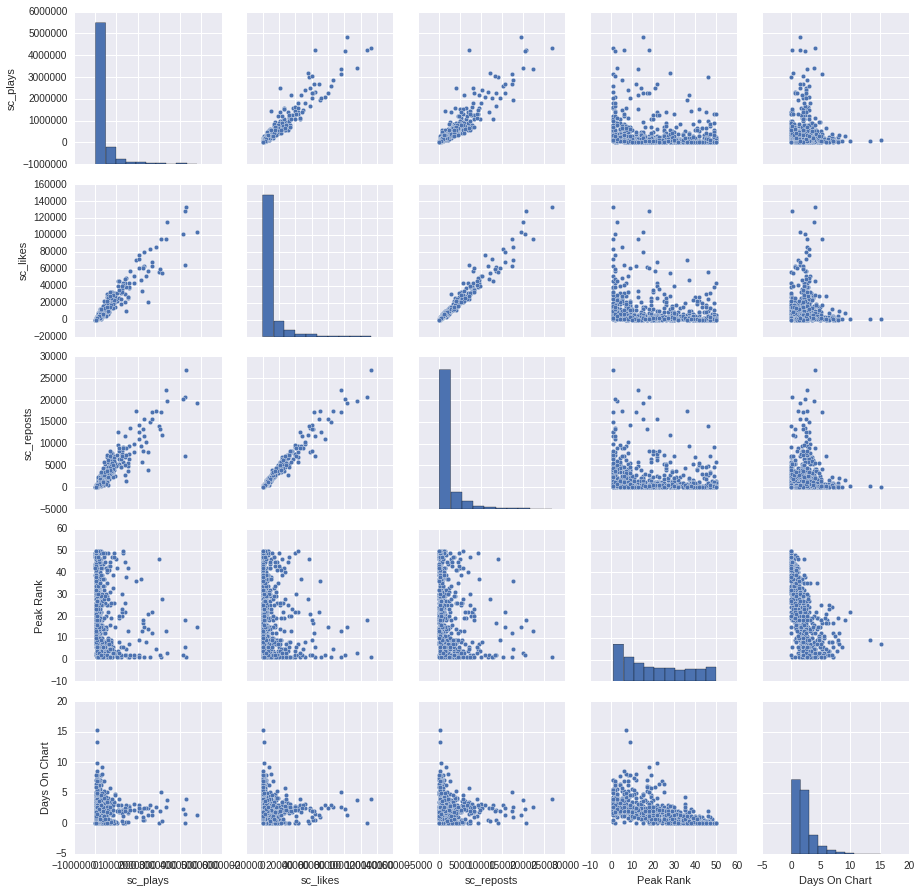

In [6]:
# Separating out the large outliers "viral"
large_examples = h_sc.loc[(h_sc["sc_likes"] > 500000) | (h_sc["sc_plays"] > 5e6)]

# Get rid of these examples from pairplot
h_sc = h_sc.loc[(h_sc["sc_likes"] < 500000) & (h_sc["sc_plays"] < 5e6)]

# Plot again
sb.pairplot(h_sc[["sc_plays", "sc_likes", "sc_reposts", "Peak Rank", "Days On Chart"]])

Much better!

Now we can observe some definite relationships between some of our variables.

1. Unsurprisingly, tracks with more plays tend to boast more likes and reposts as well, these all look correlated
2. Tracks with a lower Peak Rank (a bit backwards, 1 being the lowest but also best spot) look more likely to spend a longer time on the chart than those that peak in the double digits
3. It's hard to observe a definite trend between Peak Rank and SC Plays, but there do appear to be a cluster of tracks that reached more plays and peaked at lower number ranks

But what about our viral tracks? Let's check those out before we go too deep into our new dataset.

In [7]:
large_examples[["sc_plays", "sc_likes", "sc_reposts"]].describe()

,sc_plays,sc_likes,sc_reposts
count,8.000000e+00,8.000000e+00,8.000000
mean,4.593777e+07,7.258160e+05,73060.750000
std,3.773934e+07,5.364379e+05,34995.296144
min,7.746107e+06,1.674800e+05,24771.000000
25%,1.975981e+07,3.590425e+05,57230.000000
50%,3.058577e+07,5.672990e+05,67773.500000
75%,7.100461e+07,9.477828e+05,87927.250000
max,1.183312e+08,1.836411e+06,140933.000000


Our top track has 118 million plays! Let's check out what track that is

In [8]:
max_id = large_examples["sc_plays"].argmax()

print("Top Track:\n" + hype_m.loc[max_id,"Artist"] + " - " + hype_m.loc[max_id,"Track Title"])

Top Track:
Migos - Bad and Boujee (Feat. Lil Uzi Vert) (Prod. By Metro Boomin)


Lol. Of course it's [Migos](https://soundcloud.com/migosatl/bad-and-boujee-feat-lil-uzi-vert-prod-by-metro-boomin).

Well let's see how Bad and Boujee did on Hype Machine.

In [9]:
print("Bad and Boujee reached a top rank of: " + str(large_examples.loc[max_id, "Peak Rank"]))

Bad and Boujee reached a top rank of: 27


Hmm. Interesting, so Bad and Boujee only reached 27 on Hype Machine, probably one of the most hyped songs of the year.

One thing right away that is an issue here is that Bad and Boujee came out 8 months ago. Meaning it may have peaked higher on Hype Machine before we actually started recording data on Jan 1 of this year. Then, for some reason, in the past three months (*cough coachella*) the track resurged in popularity on the chart. This would indicate that we may need more data to draw any conclusions about this track. 

Still, let's take a look at the rest of our "viral" tracks and see how they performed on the charts.

In [10]:
viral_id = large_examples.index

viral_artists = hype_m.loc[viral_id, "Artist"]
viral_tracks = hype_m.loc[viral_id, "Track Title"]
viral_ranks = hype_m.loc[viral_id, "Peak Rank"]

print("Artist - Title:\nPeak Rank\n")

for i in viral_id:
    print(viral_artists[i] + " - " + viral_tracks[i] + ": \n" + str(viral_ranks[i])+ "\n")

Artist - Title:
Peak Rank

Migos - Bad and Boujee (Feat. Lil Uzi Vert) (Prod. By Metro Boomin): 
27

PETIT BISCUIT - Sunset Lover: 
6

Towkio - Heaven Only Knows (feat. Chance The Rapper, Lido & Eryn Allen Kane): 
26

Rob $TONE - Chill Bill: 
47

YOUNG MA - OOOUUU (intro): 
23

6LACK - PRBLMS: 
7

Kungs Vs. Cookin' On 3 Burners - This Girl: 
11

Khalid - Location: 
17



Interesting that not one of our "viral" tracks reached the top spot on Hype Machine. Nothing definitive here yet but it is giving shape to the idea that Hype Machine may not be the best predictor of "viral" tracks. Again, it is possible that these viral tracks have "re-emerged" on Hype Machine similar to Bad & Boujee. So not much we can note now except that during January to March none of our viral tracks reached the top spot on Hype Machine.

[*After checking on all of these tracks, it is the case that every one came out prior to Jan 1 and their peak rank we recorded on Hype Machine was a re-emergence. Interesting to note that tracks can make aftershock appearances even up to 1-2 years later*]

Let's return to our bigger dataset...

The next thing that may be helpful to see is a category that splits "Peak Rank" into three categories:
1. "Top 10" Tracks
2. Tracks that peaked 11-25 - "Mid-Tier"
3. Bottom Half Tracks - "Low-Tier"

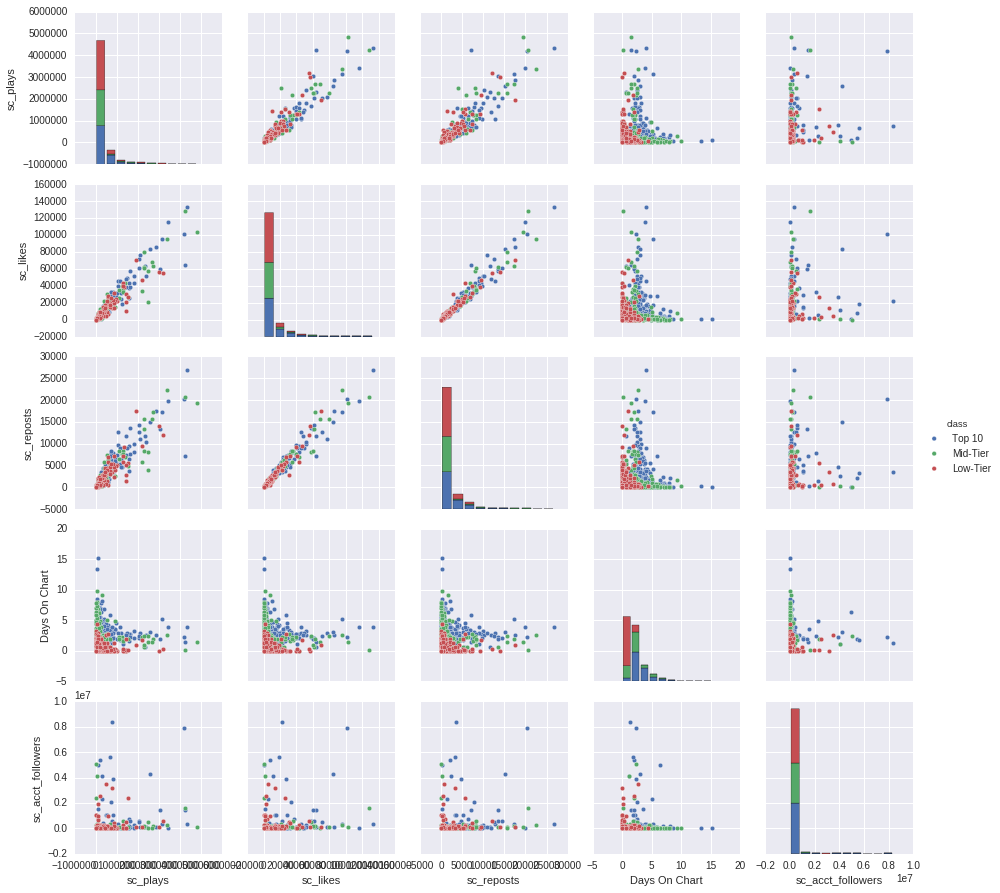

In [11]:
# Classify in an easier way
h_sc.loc[h_sc["Peak Rank"] <= 10, "class"] = "Top 10"
h_sc.loc[(h_sc["Peak Rank"] > 10) & (h_sc["Peak Rank"] < 26), "class"] = "Mid-Tier"
h_sc.loc[h_sc["Peak Rank"] > 25, "class"] = "Low-Tier"

# Plot with colors to see any grouping info
sb.pairplot(h_sc[["sc_plays", "sc_likes", "sc_reposts", "Days On Chart", 
                  "sc_acct_followers", "class"]], hue="class")

So this is cool. Definitely appears that there are some clusters. In general, low-tier tracks look to get less plays, likes, and reposts on average than mid-tier and top 10 tracks.

Violin plots may help us see this a bit more clearly.

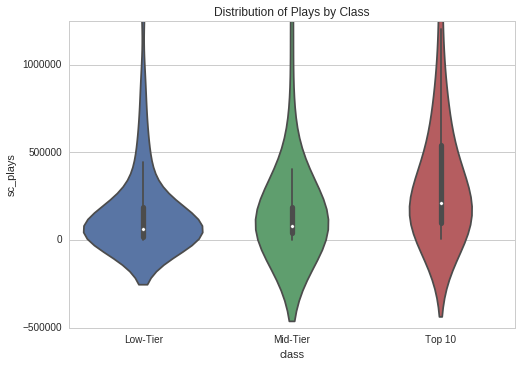

In [138]:
sb.violinplot(x="class", y = "sc_plays", data = h_sc, inner="box")
plt.ylim(-500000,1250000)
plt.title("Distribution of Plays by Class")

The white dot in the middle of the violin plot marks the median SoundCloud plays for each tier of track, the bolder and thinner black lines around the white dot measure the spread of data around the median, and the shape of the violin gives you an idea of the density of each class's distribution.

The distributions suggest there is a pattern between belonging to one of these classes and the amount of SoundCloud plays a track receives. I'm also immediately interested in what these medians are. Let's find out.

In [13]:
for cl in h_sc['class'].unique():
    print(cl + " median: " + str(int(h_sc.loc[h_sc['class'] == cl, "sc_plays"].median())) + " plays")

Top 10 median: 211912 plays
Mid-Tier median: 81512 plays
Low-Tier median: 63728 plays


Nice to see some hard numbers. Cool takeaway for an artist is that if they make it onto Hype Machine and peak in the 25-50 range they should be hoping to reach 63,728 plays or more in order to be in line with the pack. Same with Mid-Tier and Top 10: 81,512 and 211,912 respectively.

So it seems there should be a correlation between where you peak on Hype Machine and the number of plays received. Let's test that out.

In [14]:
h_sc[["sc_plays", "sc_likes", "sc_reposts", "Peak Rank", "Days On Chart"]].corr()

,sc_plays,sc_likes,sc_reposts,Peak Rank,Days On Chart
sc_plays,1.000000,0.952688,0.923642,-0.188496,0.021290
sc_likes,0.952688,1.000000,0.980607,-0.202870,0.029543
sc_reposts,0.923642,0.980607,1.000000,-0.214232,0.036271
Peak Rank,-0.188496,-0.202870,-0.214232,1.000000,-0.628771
Days On Chart,0.021290,0.029543,0.036271,-0.628771,1.000000


So a correlation of -0.188 between Peak Rank and sc_plays is pretty surprising to me. Feeling a bit low, it flies a bit against conventional wisdom that reaching the top of Hype Machine results in pretty strong exposure. 

However, there could be explanations for such a discrepancy, there still seem to be a good amount of outliers that could be skewing the data. Also, number of soundcloud followers for an artist might likely play a role in soundcloud plays.

*Another potentiality is that chunks of positions are equally boosting for SC plays.* Let's see if we segment the dataset to only include data from the top 10 if that correlation improves.

In [15]:
h_sc.loc[h_sc["class"]=="Top 10", ["sc_plays", "Peak Rank"]].corr()

,sc_plays,Peak Rank
sc_plays,1.000000,-0.237404
Peak Rank,-0.237404,1.000000


So segmenting the data to only include tracks in the top spot increased correlation between plays and peak rank by 5%. This gives a little credence to our hypothesis that segmenting into groups has an effect on correlation.

Let's check the Mid-Tier as well.

In [16]:
h_sc.loc[h_sc["class"]=="Mid-Tier", ["sc_plays", "Peak Rank"]].corr()

,sc_plays,Peak Rank
sc_plays,1.000000,-0.015675
Peak Rank,-0.015675,1.000000


WOW.

The correlation between plays and peak rank for mid-tier tracks is a near non-existent 1.5%. Giving us some idea that reaching any spot between 11 and 25 won't boost plays much more than any other spot in that segment. **Accordingly, artists should aspire to reach spots above 10 if they want to see incremental increases in plays for reaching that next higher rank. Spots 25-11 appear to be equally beneficial for boosting SoundCloud plays.**

Since we've narrowed down that grouping has an effect on the correlation between position on the chart and plays on soundcloud, I'd like to visually see how this is playing out. I'm going to plot three different scatterplots with every point in our data represented. The x-axis will be peak position, the y-axis will be number of plays, and we will separate the three classes for visual analysis.

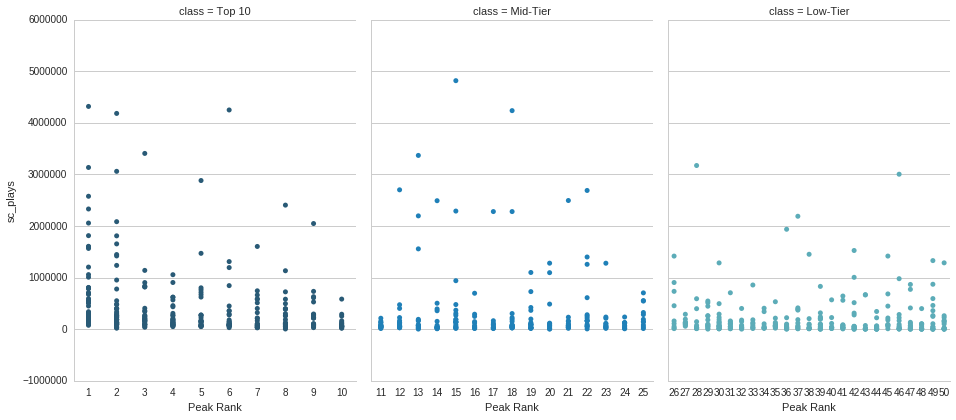

In [17]:
sb.set(style='whitegrid')
fp = sb.factorplot(x='Peak Rank', y='sc_plays', hue="class", col="class", data=h_sc,
                    palette="YlGnBu_d", size=6, aspect=.75, sharex = False, kind='strip')

axes = fp.axes
axes[0][0].set_xlim(-0.5,9.5)
axes[0][1].set_xlim(9.5,24.5)
axes[0][2].set_xlim(24.5,49.5)
fp.despine()


We definitely observe track clusters for the top 10 positions that are located higher up the SC Plays dimension than the other two classes. However, with such a large range for the y-axis (0 - 6M), it's hard to observe what's going down around 1 million and lower.

One thing that helps with this problem is performing a log-transform over our explanatory variable. This will highlight relative patterns in the data and round out our high outliers. Here's the same plot but plotted against ln(sc_plays) rather than sc_plays.

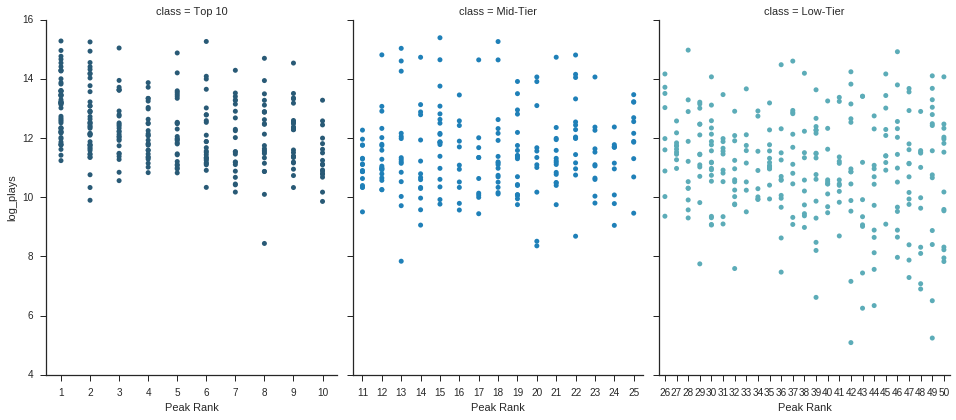

In [18]:
sb.set(style='ticks')
h_sc['log_plays'] = np.log(h_sc['sc_plays'])

fp = sb.factorplot(x='Peak Rank', y='log_plays', hue="class", col="class", data=h_sc,
                    palette="YlGnBu_d", size=6, aspect=.75, sharex = False, kind='strip')

axes = fp.axes
axes[0][0].set_xlim(-0.5,9.5)
axes[0][1].set_xlim(9.5,24.5)
axes[0][2].set_xlim(24.5,49.5)
fp.despine()

You can see that the cluster patterns are much more observable in this log-space. One thing, besides the general trend downwards when moving left to right, is also the consistency of the clusters. Up in the top ten, we see clusters that are very tight. As we move to the Mid-Tier and Low-Tier classes however, these clusters do not stay in tight packs-they spread out. This suggests that tracks reaching the top of Hype Machine tend to all receive similar amounts of plays. As we travel down the chart, a track's ranking is less and less indicative of how a track will perform on Soundcloud. This is good to keep in mind... generally an artist can depend on a certain performance out of a track if it reaches the top spots, but if that track doesn't reach the top spots, this is not necessarily indicative that a track will do poorly. Your confidence in performing well goes down, but the possibility does not disappear.

Here's a better graphic displaying exactly what I mean.

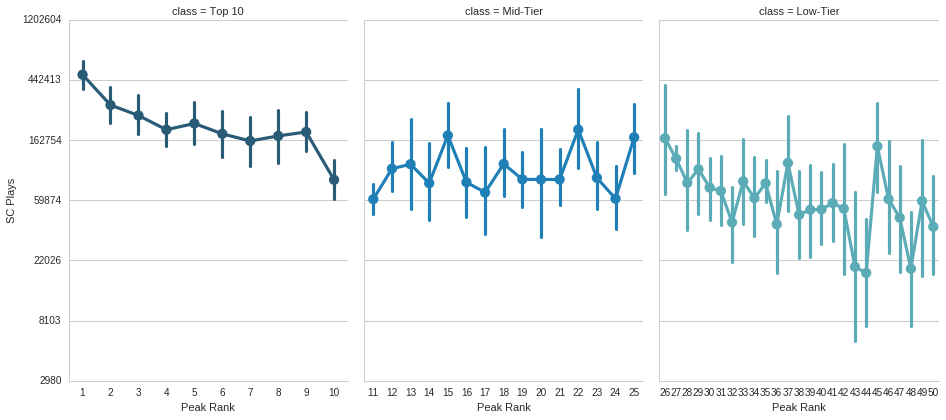

In [19]:
sb.set(style='whitegrid')
h_sc['log_plays'] = np.log(h_sc['sc_plays'])

fp = sb.factorplot(x='Peak Rank', y='log_plays', hue="class", col="class", data=h_sc,
                    palette="YlGnBu_d", size=6, aspect=.72, sharex = False, ci=90)

axes = fp.axes
axes[0][0].set_xlim(-0.5,9.5)
axes[0][1].set_xlim(9.5,24.5)
axes[0][2].set_xlim(24.5,49.5)


labels = []
y_ticks = axes[0][0].get_ymajorticklabels()
for i in y_ticks:
    l_plays = i.get_text()
    r_plays = str(int(math.exp(int(l_plays))))
    labels.append(r_plays)
                  
axes[0][0].set_yticklabels(labels)
axes[0][0].set_ylabel("SC Plays")
fp.despine()

So above you will see a point plot still represented in log-space but with our log-transform translated back to plays for readability. A point plot is an interesting graphic because it represents an estimate of *central tendency* for each group of scatterplot points. The bars surrounding each point estimate represents the uncertainty surrounding that estimate.

You'll see that a track peaking at 1 is roughly expected to fall along a distribution centered ~450k and that this is a highly confident estimate. A track peaking at 20 is expected to fall along a distribution centered ~100k but this is an estimate with much higher uncertainty.

This graph shows not only that tracks further down the chart are expected to receive less plays, but that our guess for how many plays a track receives actually gets more uncertain as tracks peak at lower tier positions.

It also gives rise to some interesting questions: 

**"Is there information out there that Hype Machine is not considering when determining chart positions?"**

-and-

**"Is there a way they could better process information so that their chart acted as a more accurate representation of a song's performance?"**

# Step 3: Mining for Stories

So far we've been doing basic exploratory analysis to really try and understand how the data aligns or doesn't alight with our understanding of music charts. Key findings included:

1. Some data points are useless since they represent a track resurgence from a previously unrecorded chart appearance.
2. Correlation between all 50 peak positions and SoundCloud performance was difficult to assess - this was eased when we split our fine-grain positions into coarser grain groups. 
3. It was then clear that Top 10 tracks tend to perform better on SoundCloud than those that do not make it to this level, BUT we have less confidence in performance predicitons for these lower tier positions.
4. Bad and Boujee is outrageously popular.

Moving forward I'd like to be able to find out some more about Hype Machine and it's ability to rank artists. This will be broken down into two sections:

#### Section A
Using unsupervised learning I will ask my computer to try and segment our data points into unique groups. I will then go back and try to interpret these groups to see if there are any patterns in the way Hype Machine treats similar artists. This will help me learn a bit more about who is using Hype Machine, who is benefitting, and perhaps where any missed oppportunities lie for Hype Machine to improve as a music chart.

#### Section B
Creating a score that encapsulates many important performance metrics is key to determining whether or not Hype Machine is doing a "good job" at identifying the best tracks. In our first section we used SoundCloud Plays as our performance metric, but there are clearly other metrics such as number of likes, reposts, and followers that may help us to determine how "good" a song is. This section will be dedicated to hypothesizing around what a score should look like, what are important metrics to take into account, and then to finally scoring all of our data points.

## Section A

First I need to import a few more libraries:

In [20]:
from sklearn import decomposition
from sklearn import cluster
from pandas.tools.plotting import parallel_coordinates, andrews_curves, radviz

The first step I'll take in classifying our tracks into groups is to do what's known as Principal Component Analysis. A wonderful and accessible explanation of this technique can be found [here](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues). 

In summary PCA transforms our variables by combining and scaling them, thereby producing new variables. The strategy here is to reduce the dimensionality of our dataspace and identify those planes along which the variance in our data is the most effectively observed.

In [21]:
pca = decomposition.PCA()
# New dataset with only integer variables
h_int = h_sc[["Peak Rank", "SC Repost to Play Ratio", "sc_acct_followers", "sc_likes",
              "sc_plays", "sc_reposts", "SC Like to Play Ratio", "Days On Chart", "Number of Re-Emergences"]]
pca.fit(h_int)
print(pca.explained_variance_)

[  5.26844213e+11   3.02321457e+11   2.55731634e+07   3.78167878e+05
   2.26682110e+02   2.33650503e+00   8.19243747e-01   9.52484659e-05
   1.22689961e-06]


Above we see our new variables' explained variance as a list. How we will reduce dimensionality is by keeping variables that explain large amounts of variance while dropping those that explain smaller amounts of variance. I have chosen to keep the first 5 (larger numbers), while dropping the last 4 (smaller numbers).

In [22]:
pca.n_components = 5
int_reduced = pca.fit_transform(h_int)
int_reduced = pd.DataFrame(int_reduced)
# Sanity check, should be (789,5)
int_reduced.shape

(789, 5)

Now, in this PCA-space, we will perform KMeans clustering to break up our data points into representable groups. Let's plot our groups and observe how they were broken up. 

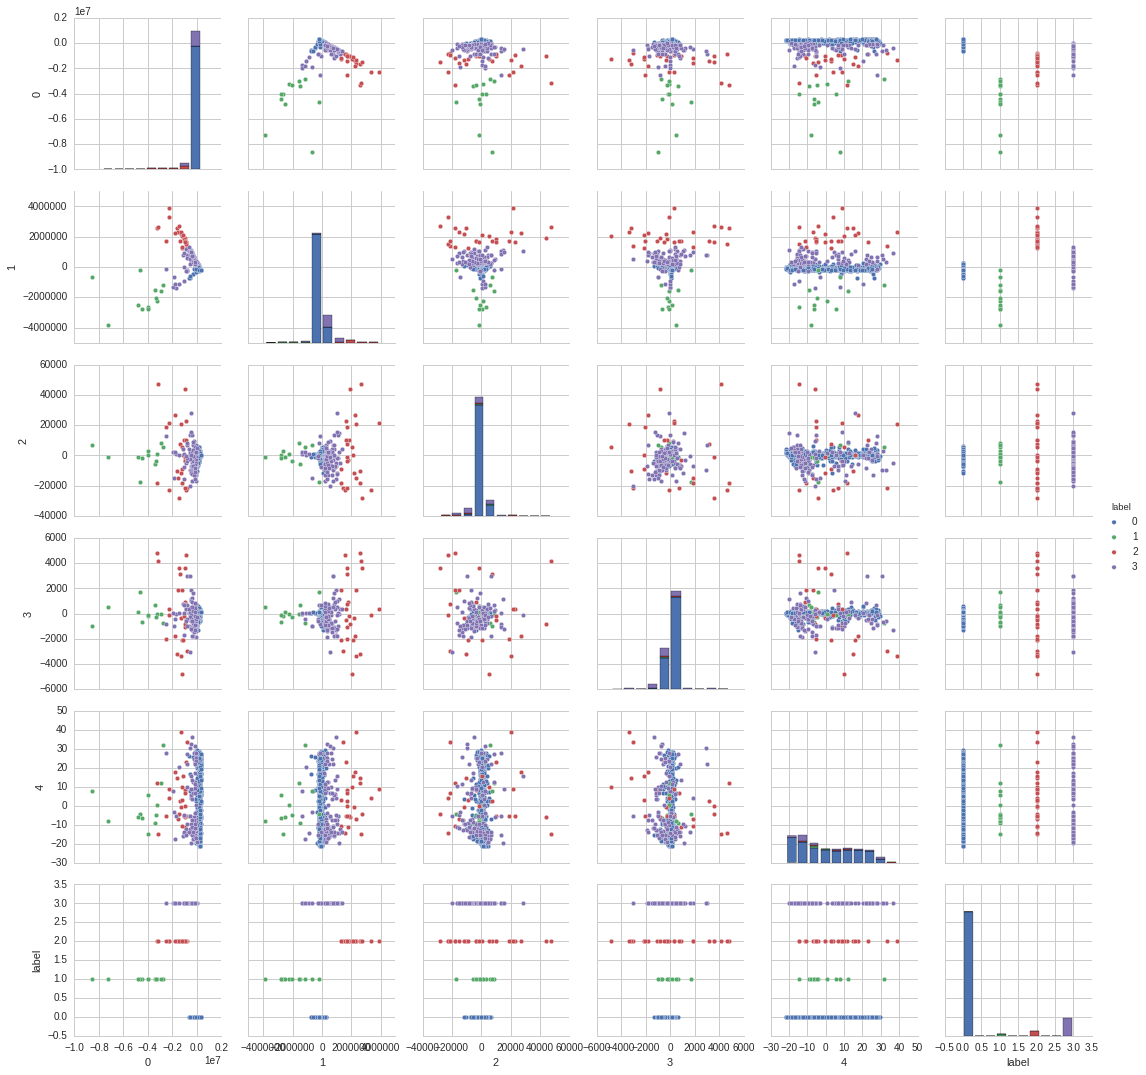

In [23]:
k_means = cluster.KMeans(n_clusters = 4)
k_means.fit(int_reduced)

int_reduced["label"] = k_means.labels_
sb.set(style='whitegrid')
sb.pairplot(int_reduced, hue = 'label')

Above you can see the groups our algorithm identified as they exist in our PCA space. Notice the axes aren't directly interpretable since our PCA algorithm combined and transformed our original variables in order to create this space. It looks like our KMeans model did a pretty reasonable job of finding clusters.

Now, below, let's transfer our labels for each observation to our original dataset and return to our interpretable dataspace.

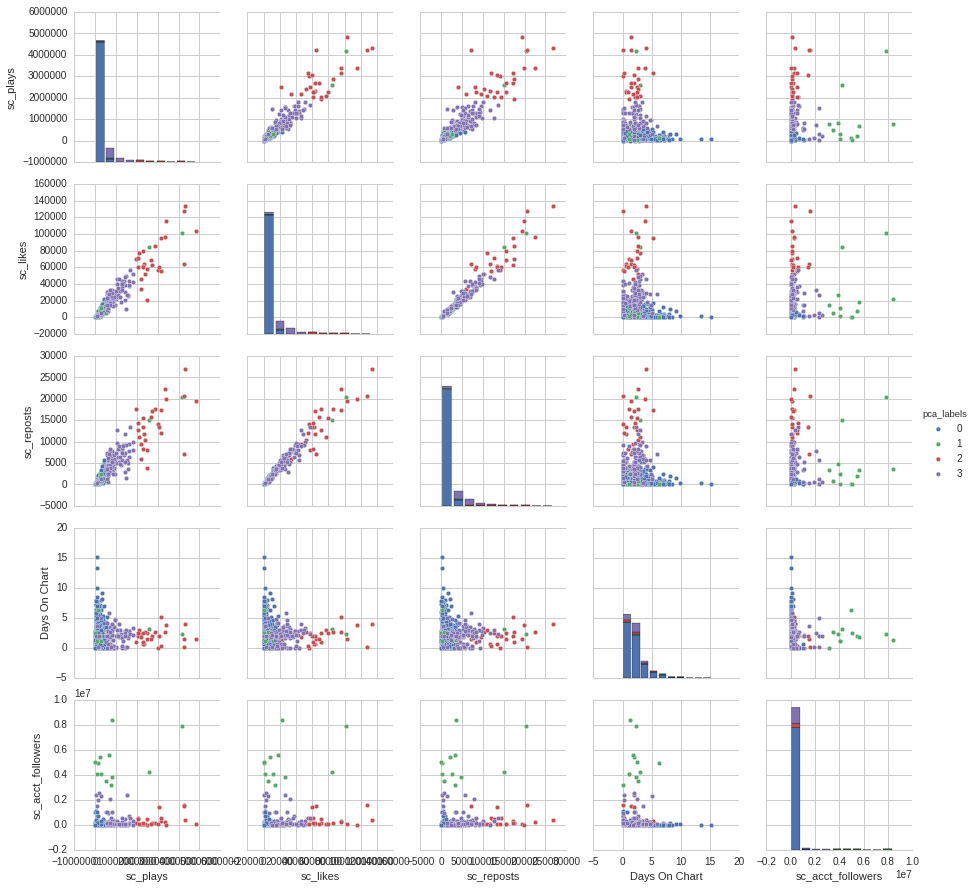

In [24]:
h_sc["pca_labels"] = k_means.labels_
sb.pairplot(h_sc[["sc_plays", "sc_likes", "sc_reposts", "Days On Chart", 
                  "sc_acct_followers", 'pca_labels']], vars = ["sc_plays", 
                  "sc_likes", "sc_reposts", "Days On Chart", 
                  "sc_acct_followers"], hue = 'pca_labels')

It looks like our work in PCA-space translated into nice interpretable results! Most notably I can see that one of our groups looks to exclusively include tracks belonging to artists who have a high soundcloud following of above 300,000. Observed along the bottom row. 

Another group looks to be composed of tracks that received a high number of plays. The two remaining groups look like they blend a bit together, we may have to dig deeper to see the relationships between those two.

In [25]:
# Making categories so they display correctly
h_sc['class'] = h_sc['class'].astype('category', ordered = True)
h_sc['pca_labels'] = h_sc['pca_labels'].astype('category', ordered = True)

One way to observe clear differences between the groups identified is to plot our observations as lines connecting two coordinate axes. This is known as parallel coordinate plotting. Since we identified both Soundcloud Plays and SC Acct Followers as both fairly deterministic planes for our clusters, let's plot those two axes and see if we can spot some patterns in line location.

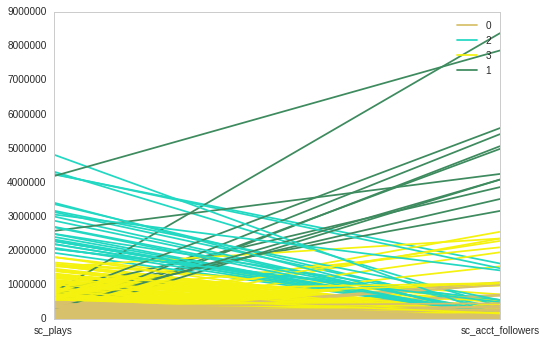

In [26]:
parallel_coordinates(h_sc[['sc_plays','sc_acct_followers', 'pca_labels']], 'pca_labels')

So immediately we can spot one group, Group 1, that can be identified by a generally high following on Soundcloud accompanied by generally lower plays. All lines in this group are slanting up, meaning they have smaller play to following ratios. 

Another group that appears immediately obvious is Group 2 which exhibits a tendency towards relatively high plays with relatively lower followings. This might indicate a group of artists who are relatively smaller and have managed to accumulate a proportionately high amount of plays. This very much aligns with the ethos of Hype Machine, which prides itself on being a platform of music discovery. A group of relatively unknown artists who "hit it big" on Hype Machine would support this message and indicate a healthily working music discovery platform. We'll explore more to see what we can find out about this group of interest.

The remaining two groups are a bit too cluttered in this chart to decipher much, but it does seem at least a bit reasonable to state that Group 3 tends towards higher plays and a wider spread of following than Group 0 does. Let's take a closer look at exactly how many observations are in each group and what their compositions are in terms of Top 10, Mid-Tier, and Low-Tier tracks.

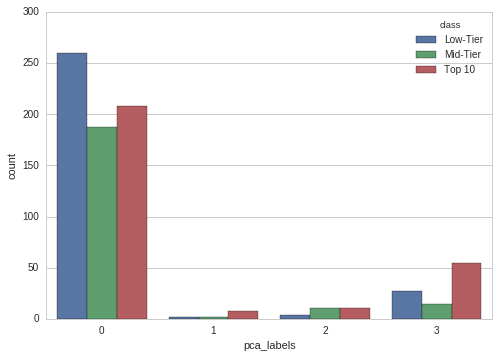

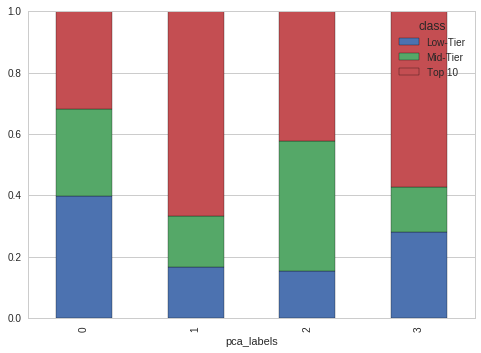

In [27]:
sb.countplot(data = h_sc[['pca_labels', 'class']], x = 'pca_labels', hue = 'class')
    
label_cross = pd.crosstab(h_sc['pca_labels'], h_sc['class'])
label_cross.div(label_cross.sum(1).astype(float), axis = 0).plot(kind='bar', stacked = True)

So Group 0 absolutely dwarfs all our other groups in terms of size, also interesting to note that it tends to display a proportionately higher amount of Low-Tier tracks than any of the other groups. Let's check out exactly how large this group is.

### Group 0

In [28]:
count_group = h_sc['pca_labels'].value_counts().argmax()
count_max = h_sc['pca_labels'].value_counts().max()

print("Biggest Group:\nGroup " + str(count_group) + ' - ' + str(count_max) + ' tracks')
print('\nPercentage: ' + str(count_max/h_sc['pca_labels'].count()))

Biggest Group:
Group 0 - 655 tracks

Percentage: 0.830164765526


This is obviously alarge percentage of our total observations, we will most likely wish to explore this group further with more clustering in a bit. For now however, let's continue looking at our other groups. I'd like to be able to rename each of these groups according to the story of their experience on Hype Machine. Hopefully this gives us some better insight into how the chart is performing for different groups of artists.

**I will choose to name this large group we just examined "The Herd"**. Since it represents a majority of tracks observed on Hype Machine, doesn't display the explosive play numbers associated with Hype Machine royalty, and contains the largest percentage of low-charting tracks, I think it's fair to assume that this is the average user's experience with charting on Hype Machine.

Next let's look closer at that group which tends towards large followings on Soundcloud.

### Group 1

In [29]:
h_mean_fol = 0
fol_group = -1

for i in h_sc['pca_labels'].unique():
    cur_mean = h_sc.loc[h_sc['pca_labels'] == i, 'sc_acct_followers'].mean()
    if cur_mean > h_mean_fol:
        fol_group = i
        h_mean_fol = cur_mean
        
print("Highest Followers:\nGroup " + str(fol_group) + ' - ' + str(h_mean_fol) + ' followers')

Highest Followers:
Group 1 - 5020959.75 followers


The average artist in this group has a following of greater than 5 million! That's incredible, these are obviously huge artists so I'm curious who they are. It's a manageably sized group so let's find out who we have here...

In [30]:
temp_index = h_sc.loc[h_sc['pca_labels'] == fol_group].index

In [31]:
c = 0
r_c = 0

for idx in temp_index:
    print(hype_m.loc[idx, 'Artist'] + ' - ' + hype_m.loc[idx, 'Soundcloud Link'])
    if not pd.isnull(hype_m.loc[idx, 'Remix Artist']):
        print('Remix Artist - ' + str(hype_m.loc[idx, 'Remix Artist']))
        r_c += 1
    c += 1
    print('\n')
    
# For WALE who names his tracks weirdly
r_c += 1
print('Percent Remix = ' + str(r_c/c))

Maya Jane Coles - https://soundcloud.com/mayajanecoles/burning-bright-ft-kim-ann


Local Natives - https://soundcloud.com/local-natives/dark-days-sofi-tukker-remix
Remix Artist - Sofi Tukker Remix


Father John Misty - https://soundcloud.com/subpop/father-john-misty-ballad-of-the-dying-man


Ella Vos - https://soundcloud.com/r3hab/ella-vos-white-noise-r3hab-remix
Remix Artist - R3hab Remix


WALE - https://soundcloud.com/walefolarin/shape-of-you-remix


AlunaGeorge - https://soundcloud.com/alunageorge/not-above-love-devault-remix
Remix Artist - DEVAULT Remix


Steve Aoki & Louis Tomlinson - https://soundcloud.com/steveaoki/just-hold-on-attom-remix-1
Remix Artist - Attom Remix


Zedd - https://soundcloud.com/zedd/stay


The Lumineers - https://soundcloud.com/dualtone/the-lumineers-naive-melody


Bob Moses - https://soundcloud.com/rac/tearing-me-up-rac-mix
Remix Artist - RAC Mix


Steve Aoki & Louis Tomlinson - https://soundcloud.com/steveaoki/just-hold-on-two-friends-remix-1
Remix Artis

We have some enormous artists observed here: Lana Del Rey, Maya Jane Coles, Steve Aoki, Zedd, AlunaGeorge, etc...

From our parallel coordinates plot we observed that this group performed rather modestly on SoundCloud compared to their astronomical followings. I think we may have a bit of explanation for that here. Most (2/3) of these tracks are remixes by other artists. It is possible that these large artists hosted these remixes but perhaps did not put in the large-scale promotional effort that they would have done for an original release of their own.

#### *My Theory:*
This group does have a high percentage of Top-Tier tracks but I doubt that these large artists personally get involved with charting on Hype Machine, the remix artists probably were doing more of the grunt work hence the proportionally lower play counts. The large artists' hands-off mentality is indicative of their relationship with Hype Machine. Hype Machine seems to have the ability to boost plays, but only so far. Clearly larger artists such as Lana Del Rey are finding other venues to fuel their success. These artists are proportionally bigger in clout than Hype Machine and thus charting matters much less to them, in fact Hype Machine more likely benefits from the name recognition of the large artist. The remix artists enjoy both a pull upwards from association with these large Soundcloud followings and also a top spot on Hype Machine. It seems like a nice little tradeoff all around.

**Henceforth I shall call this group "2 Big 2 Care"**.

The next group I'll look into is that group that exhibited higher Soundcloud plays on their tracks with proportionately lower Soundcloud following:

### Group 2

In [32]:
h_mean_plays = 0
plays_group = -1

for i in h_sc['pca_labels'].unique():
    cur_mean = h_sc.loc[h_sc['pca_labels'] == i, 'sc_plays'].mean()
    if cur_mean > h_mean_plays:
        plays_group = i
        h_mean_plays = cur_mean
        
print("Highest Plays:\nGroup " + str(plays_group) + ' - ' + str(h_mean_plays) + ' plays')

Highest Plays:
Group 2 - 2850683.6923076925 plays


This group averaged almost 3 million plays among them, how many tracks do we have here?

In [33]:
h_sc.loc[h_sc['pca_labels'] == plays_group, "sc_acct_followers"].count()

26

Let's take a look at those observations with the lowest following...

In [34]:
index2 = h_sc.loc[h_sc['pca_labels'] == plays_group, "sc_acct_followers"].nsmallest(10).index

print('Lowest Following in Highest Plays Group:')
hype_m.loc[index2, ['sc_acct_followers', 'sc_plays', 'Soundcloud Link', 'Artist', 'Track Title']]

Lowest Following in Highest Plays Group:


,sc_acct_followers,sc_plays,Soundcloud Link,Artist,Track Title
274,414.0,2490417.0,https://soundcloud.com/dhat-girl-coco/big-sean...,Big Sean,Control (feat. Kendrick Lamar & Jay Electronica)
820,880.0,3406887.0,https://soundcloud.com/myguyprettylikeagirl/fr...,Frank Ocean,Chanel (Remix) (feat. A$AP Rocky)
813,31816.0,2688954.0,https://soundcloud.com/mindofageniusrecords/zh...,ZHU x Skrillex x THEY.,Working For It (Zane Lowe World
752,70636.0,2289651.0,https://soundcloud.com/joeybadass/landofthefree,Joey Bada$$,LAND OF THE FREE
583,71281.0,2189116.0,https://soundcloud.com/unofficialthey/motley-crue,THEY.,Motley Crue
811,71282.0,4816769.0,https://soundcloud.com/unofficialthey/back-it-...,THEY.,Back It Up
329,72007.0,2196395.0,https://soundcloud.com/koni_music/the-weeknd-s...,Koni,The Weeknd – Starboy
27,85037.0,2280003.0,https://soundcloud.com/wearelostkings/phone-down,Lost Kings,Phone Down
642,86894.0,2084109.0,https://soundcloud.com/taylorbennetttunes/grow...,Taylor Bennett,Grown up fairy Tales feat. Chance The Rapper &...
587,87523.0,3003903.0,https://soundcloud.com/thisnao/nao-vs-a-k-paul...,Nao vs. A. K. Paul,So Good


There are two accounts with unusually small following, after following the links I found out that these are illegal uploads by unknown Soundcloud users. Obviously Big Sean and Frank Ocean are huge artists and would have much larger followings. Ignoring those two accounts, the third smallest follwing is a track by Zhu, Skrillex, and They. These are all fairly large names and if you inspect the soundcloud link you can see that the small following is actually explained away by being hosted on Mind of a Genius's SC acct. (MOAG is the record label associated with ZHU so this makes sense. 

I'm starting to get the feeling that our initial insight into this group being comprised of smaller artists is not very accurate. All artists appear to be fairly big and very hyped. Let's take a looka at the most followed in this group.

In [35]:
index2 = h_sc.loc[h_sc['pca_labels'] == plays_group, "sc_acct_followers"].nlargest(10).index

print('Highest Following in Highest Plays Group:')
hype_m.loc[index2, ['sc_acct_followers', 'sc_plays', 'Soundcloud Link', 'Artist', 'Track Title']]

Highest Following in Highest Plays Group:


,sc_acct_followers,sc_plays,Soundcloud Link,Artist,Track Title
60,1621578.0,4236127.0,https://soundcloud.com/martingarrix/stbl,Martin Garrix & Dua Lipa,Scared To Be Lonely
552,1482577.0,4249015.0,https://soundcloud.com/chancetherapper/strange...,Chance The Rapper,Stranger At The Table
924,1419633.0,3059774.0,https://soundcloud.com/madeon/youre-on-ft-kyan...,Madeon,You're On feat. Kyan
467,553938.0,2047882.0,https://soundcloud.com/kaytranada/solange-cran...,Solange,Cranes in the Sky
588,548436.0,3172417.0,https://soundcloud.com/futureclassic/touch-sen...,Touch Sensitive,Pizza Guy
849,486726.0,2057174.0,https://soundcloud.com/flatbushzombies/babel,Flatbush ZOMBiES,Babel (Prod. By The Architect)
67,479038.0,2494161.0,https://soundcloud.com/kehlanimusic/undercover,Kehlani,Undercover
210,367002.0,4317777.0,https://soundcloud.com/sanholobeats/light,San Holo,Light
269,304558.0,3134721.0,https://soundcloud.com/illeniumofficial/illeni...,Illenium,Fractures (feat. Nevve)
409,231992.0,3368033.0,https://soundcloud.com/louisthechild/fire-1,Louis The Child,Fire


So now it is very clear that this group is not the "rags to riches" story we initially hoped to observe. Instead, I would say that **these artists appear to exist more along the lines of Hype Machine "Royalty"**. That type of artist you would expect to see charting 1 or 2 on any given day. Those who live in the balanced purgatory between being almost too big for Hype Machine but yet still enjoying the credability that comes along with robust blog exposure. 

### Group 3

We have one final group left without an identity. While looking for a way to distinguish our final group I decided to look at a metric that was often emphasized at my last job, overseeing a large network of curated music channels. Measuring a track's success can be difficult, one way to track fan engagement with an upload is to look at its percentage of likes to plays. Put quite simply, the higher a track's like-to-play (ltp), the better the track is performing.

Here I need to put out a disclaimer, tracks that get more plays tend to have smaller ltp's. This can be expected due to a variety of reasons, the most compelling of which is repeat plays. One user plays the track twice, three times, 100 times because they enjoy it, but this user can only like a track one single time. Plays get saturated and the ltp goes down. But in reality a user playing a track 100 times should actually be an indication that the track is doing better, not worse. So this method cannot be a hard and fast rule but it is a nice place to start with no other option. 

Below is a violin plot of each group's ltp distribution. As you can see our "Herd" group has the lowest, as expected. Our final unidentified group has the highest median ltp! This gives us a metric around which to identify this group, and more importantly gives us an insight into this group's quality of track. It seems this group contains tracks with very good listener engagement.

One final note, the fact that our "Royalty" group has the second highest median ltp with the highest average amount of plays, keeping in mind the play saturation issue mentioned above, speaks to just how strong those tracks are...

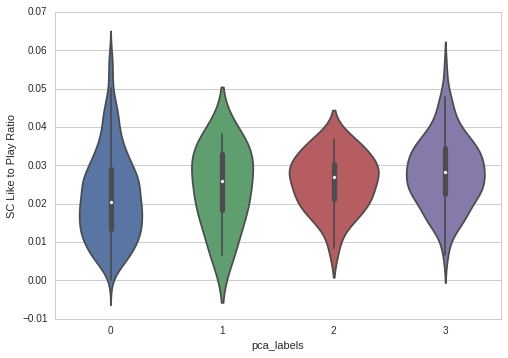

In [36]:
sb.violinplot(x = "pca_labels", y = "SC Like to Play Ratio", data = h_sc)

So what is the average ltp for our final group?

In [37]:
h_mean_ltp = 0
ltp_group = -1

for i in h_sc['pca_labels'].unique():
    cur_mean = h_sc.loc[h_sc['pca_labels'] == i, 'SC Like to Play Ratio'].mean()
    if cur_mean > h_mean_ltp:
        ltp_group = i
        h_mean_ltp = cur_mean
        
print("Highest LTP:\nGroup " + str(ltp_group) + ' - ' + str(h_mean_ltp) + ' Mean Likes to Plays')

Highest LTP:
Group 3 - 0.028288323612912655 Mean Likes to Plays


And who do we have in this group?

In [38]:
index3 = h_sc.loc[h_sc['pca_labels'] == ltp_group, "SC Like to Play Ratio"].nlargest(15).index

hype_m.loc[index3, ['Artist', 'Track Title', 'sc_plays', 'sc_likes', 'SC Like to Play Ratio', 'sc_acct_followers']]

,Artist,Track Title,sc_plays,sc_likes,SC Like to Play Ratio,sc_acct_followers
406,Tennyson x Mr. Carmack,Tuesday,554519.0,30453.0,0.054918,86332.0
173,REZZ X K?D,FOURTH IMPACT,569099.0,27192.0,0.047781,81303.0
762,MICK JENKINS,Pressed for time (Crossed my mind) Feat. GoldLink,590630.0,27827.0,0.047114,196843.0
961,SNBRN & BLU J,You Got Me feat. Cara Frew,708046.0,32908.0,0.046477,155029.0
550,Flume,Depth Charge,724080.0,33051.0,0.045646,2096632.0
548,ZHU x MIGOS,ZHU x MIGOS - Bad and Boujee.,1057944.0,46014.0,0.043494,335947.0
921,Louis Futon,Surreal (Feat. RKCB),670822.0,27605.0,0.041151,99220.0
917,Kill Paris,Good Love,610782.0,25044.0,0.041003,174655.0
359,Autograf,Nobody Knows (feat. WYNNE),809221.0,32999.0,0.040779,137374.0
929,Bebe Rexha,I Got You,560958.0,22571.0,0.040237,155029.0


This group seems to be comprised of some really great artists and really great tracks. We have Flume, Mr. Carmack, Childish Gambino... Those types of artists that consistently put out quality music and do very well among the blog scene. A few of these artists flirt with major label affiliation but for the most part I would categorize them in a space of consistent festival appearances, independent credibility, and younger more in touch fanbases. Not quite the mainstream radio success as those in our "2 big 2 care" and "Royalty" groups, but successful in their own space and leveraging Hype Machine to their success. It's the kind of artist you would expect Red Bull and other "hip brands" to partner with. It's also that type of artist Hype Machine loves to keep involved with their chart and help to support with exclusive partnerships. This group represents the future mainstream in some aesthetic sense.

**I'll label this group our "Golden Child"**.


### Our 4 Major Groups

So there we are, our model has identified 4 varying groups in our data and we have been able to interpret these groups into discernible artists with similar stories and similar relationships with Hype Machine. Pretty cool. Time to rename them.

1. The Herd
2. Golden Child
3. Royalty
4. 2 Big 2 Care

In [39]:
# Reorder then rename
h_sc['pca_labels'] = h_sc['pca_labels'].cat.reorder_categories([count_group, ltp_group, plays_group, fol_group], 
                                                               ordered = True)
h_sc['pca_labels'] = h_sc['pca_labels'].cat.rename_categories(['The_Herd', 
                                                               'Golden_Child', 
                                                               'Royalty', 
                                                               '2_Big_2_Care'])

We have renamed our groups, now let's take a look at the same charts now with discernible labels.

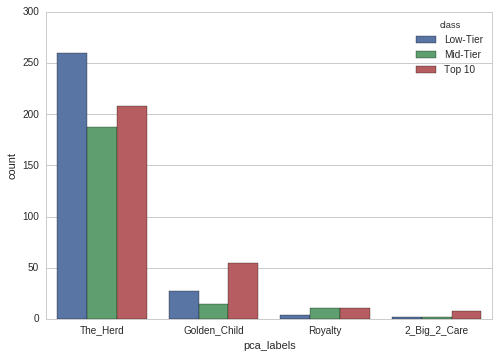

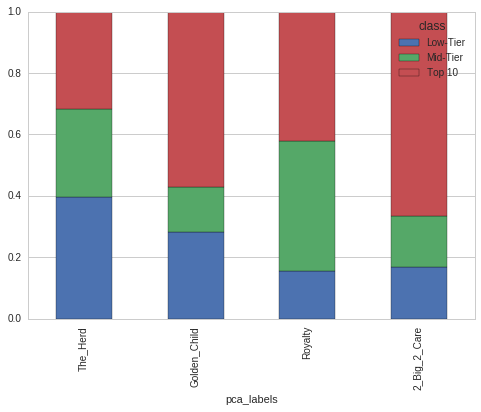

In [40]:
sb.countplot(data = h_sc[['pca_labels', 'class']], x = 'pca_labels', hue = 'class')

label_cross = pd.crosstab(h_sc['pca_labels'], h_sc['class'])
label_cross.div(label_cross.sum(1).astype(float), axis = 0).plot(kind='bar', stacked = True)

Now these charts make a lot more sense. Returning to "The_Herd" for a second, it would be nice to split this group up further and understand even better what's going on for a majority of Hype Machine charting artists.

## Sub-Groups in "The Herd"

So let's do the same PCA-to-KMeans technique we used before, but I'll make a few alterations now that I'm more comfortable and familiar with the data and how it will respond to these models.

In [41]:
# Create new dataframe
the_herd = h_sc.loc[h_sc['pca_labels'] == "The_Herd"]
# Sanity check - length should be 655
assert the_herd['sc_plays'].count() == 655
the_herd = pd.DataFrame(the_herd)

First thing I'll do this time around is log-transform some of our variables. This will reduce outliers on the large end, which our data tends to exhibit, even in this segmented partition.

In [42]:
the_herd['log_rp'] = np.log(the_herd['sc_reposts'] + 1e-5)
the_herd['log_likes'] = np.log(the_herd['sc_likes'] + 1e-5)
the_herd['log_fol'] = np.log(the_herd['sc_acct_followers'])

Again, PCA

In [43]:
pca_herd = decomposition.PCA()
# New dataset with chosen variables
herd_int = the_herd[["SC Repost to Play Ratio", "log_fol",
               "SC Like to Play Ratio", "Days On Chart", "Number of Re-Emergences"]]
pca_herd.fit(herd_int)
print(pca_herd.explained_variance_)

[  4.44221157e+00   3.75382858e+00   1.04045595e+00   1.05208532e-04
   1.52065116e-06]


I'll keep the top three scoring variables this time.

In [44]:
pca_herd.n_components = 3
herd_reduced = pca_herd.fit_transform(herd_int)
herd_reduced = pd.DataFrame(herd_reduced)
# Sanity check, should be (655,3)
herd_reduced.shape

(655, 3)

Now KMeans again, and plot our transformed dataspace to observe clusters. I'm clustering into 5 groups this time, this is a hyperparameter. I liked the results of 5, generally 3 is uninteresting because it gives you a small, medium, and large group. 4 or 5 tend to give more interesting results, choose group numbers much more than that and you're starting to deal with an unwieldy amount of classes to interpret.

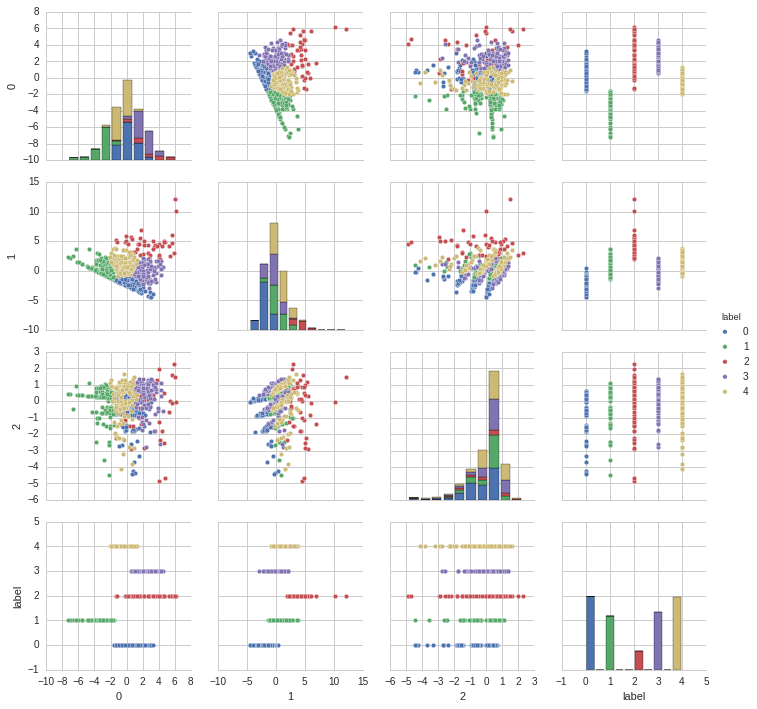

In [45]:
k_means2 = cluster.KMeans(n_clusters = 5)
k_means2.fit(herd_reduced)

herd_reduced["label"] = k_means2.labels_
sb.set(style='whitegrid')
sb.pairplot(herd_reduced, hue = 'label')

Pretty. Now let's transfer labels back to interpretable dataspace and observe translated clusters.

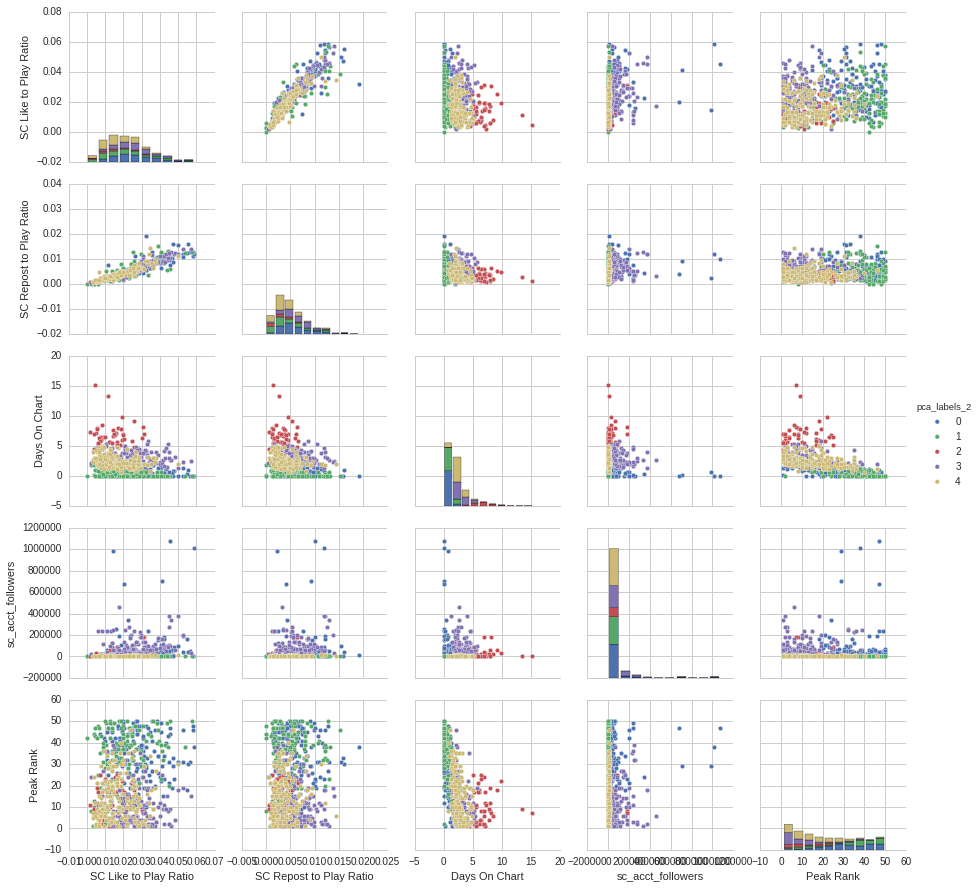

In [46]:
the_herd["pca_labels_2"] = k_means2.labels_

sb.pairplot(the_herd, vars = ["SC Like to Play Ratio", 
                  "SC Repost to Play Ratio", "Days On Chart", 
                  "sc_acct_followers", "Peak Rank"], hue = 'pca_labels_2')

### Classifying our Sub-Groups

Our groups translated into interpretable clusters among our dataspace. Instead of splitting these groups by hand this time, I'll use a classification model to see if our computer can interpret the clusters for me.

I'll be using a Decision Tree Classifier here. Decisions Trees work by asking a series of A or B questions about the datapoints and classifying them as they continue to split. The classifier will continue to split until it reaches an appropriate level of confidence in it's classification ability. This confidence is measured in entropy or level of confusion the model has regarding classification. The lower the entropy, the more confident the model is in its splits and decision making.

First I'll import some more libraries we'll need

In [47]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
import sklearn.tree as tree
from sklearn.externals.six import StringIO

Now I'll split our data into two sets, the X variables we'd like our model to make splits around, and our y variable we'd like our model to use for classification.

In [48]:
all_inputs = the_herd[['sc_plays', 'sc_likes', 'sc_reposts', 'SC Repost to Play Ratio', 'SC Like to Play Ratio',
                     'sc_acct_followers', 'Peak Rank', 'Days On Chart', 'Number of Re-Emergences']].values
all_classes = the_herd['pca_labels_2'].values



The best way to determine a model's accuracy in Machine Learning is to split our data into a group we train our model with, and a group that is used for testing. This ensures our model can generalize to a larger population and isn't just learning to classify our subset extremely well. 

To see how splitting our data skews results let's perform our train/test split 1000 times and plot the accuracy we get each time.

/home/jmoso13/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


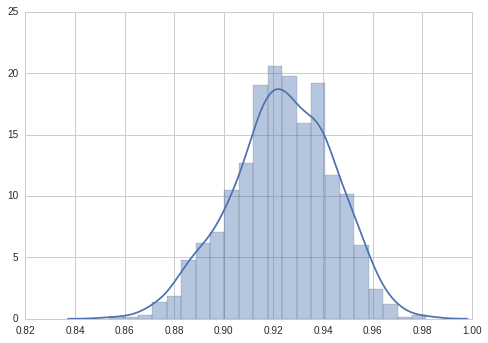

In [49]:
model_accuracies = []

for i in range(1000):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75)
    
    dtc = DecisionTreeClassifier()
    dtc.fit(training_inputs, training_classes)
    acc = dtc.score(testing_inputs, testing_classes)
    model_accuracies.append(acc)
    
sb.distplot(model_accuracies)

Obviously we would prefer not to have this much variance surrounding the accuracy of our model. Depending on how we split the data we could achieve around 85% accuracy all the way up to around 97%. One way to combat this is to do cross-validation by splitting our group up in many different subsets and taking turns training our model on different combinations.

Below I split our data into 10 subsets and perform cross-validation.

/home/jmoso13/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


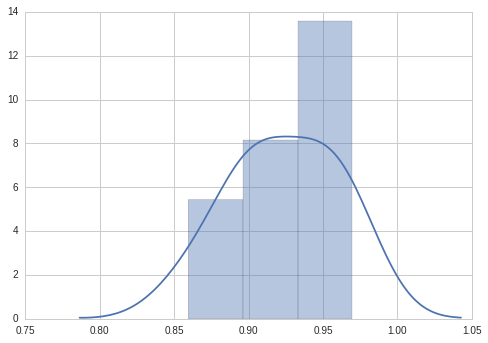

In [64]:
dtc = DecisionTreeClassifier()

cv_scores = cross_val_score(dtc, all_inputs, all_classes, cv=10)
sb.distplot(cv_scores)

This looks much less spread out. Good.

Our model can take many parameters, below we're searching for the best combination of parameters we can find.

In [51]:
dtc = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7],
                  'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

cross_validation = StratifiedKFold(all_classes, n_folds=10)

grid_search = GridSearchCV(dtc,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9282442748091603
Best parameters: {'max_depth': 6, 'max_features': 8}


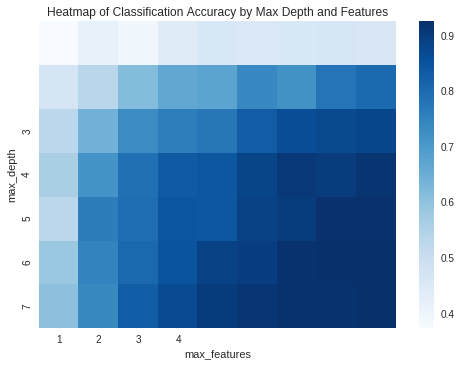

In [52]:
grid_visualization = []

for grid_pair in grid_search.grid_scores_:
    grid_visualization.append(grid_pair.mean_validation_score)
    
grid_visualization = np.array(grid_visualization)
grid_visualization.shape = (7,9)
sb.heatmap(grid_visualization, cmap='Blues')
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'][::-1])
plt.xlabel('max_features')
plt.ylabel('max_depth')
plt.title('Heatmap of Classification Accuracy by Max Depth and Features')

The important takeaway is that increasing the amount of features used and the allowable depth of our tree classifier helps in achieving greater accuracy.

Now we'll finetune the model.

In [53]:
dtc = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [5, 6, 7],
                  'max_features': [5, 6, 7, 8, 9]}

cross_validation = StratifiedKFold(all_classes, n_folds=10)

grid_search = GridSearchCV(dtc,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9389312977099237
Best parameters: {'max_depth': 7, 'splitter': 'best', 'criterion': 'entropy', 'max_features': 9}


Our best score is around 94% accuracy, this is pretty good. We're also fairly sure our model isn't overfitting which is great news.

Let's save our model and visualize it so we can interpret how our classifier separates our clusters.

In [54]:
dtc = grid_search.best_estimator_
dtc

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=9, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [55]:
with open('classes.dot', 'w') as out_file:
    out_file = tree.export_graphviz(dtc, out_file=out_file)

![Decision Tree](files/new_classes.png)

Above you can see a snapshot of our decision tree output (the full tree is much larger). As you can see, the classifier continues to make splits based on a choice variable. X[5] refers to the "sc_acct_followers" variable, so our first split can be interpreted as: observations who have less than 11,498 followers on Soundcloud split to the left vs those who have more split to the right. If you look down each branch, as entropy goes down, our decision tree is more confident making classification guesses. The list of numbers at the bottom refers to how many samples from each class exist at that node. For example, at our first head node, we observe 174 observations in class 0, 128 in class 1, 45 in 2, etc...

You can begin to interpret groups by looking at where splits occur and which classes tend to follow certain paths. It's clear from our first split that the group most likely to contain artists with a following greater than 11,498 is "Group 3". This is true for all 136 observations in that group. "Group 2" is split down the middle, 25 below and 20 above, and "Group 0" contains a majority of artists with larger than 11,498 followers. Also not one artist contained in "Group 1" has a following larger than 11,498. This gives you a good idea for the general makeup of each group, and of course as the decision tree continues to split you can more and more insight into each group's composition.

Here are the other split variables so you can do a bit of interpretation yourself:
- X[5] = Number of followers on SC
- X[7] = Days Spent on Chart
- X[8] = Number of times a track dropped off the chart and then re-emerged

In [75]:
labels = [3,1,2,4,0]

### Interpreting our Sub-Groups

After some careful analysis of the splits, my initial interpretation of each group:

### - Group 3 - "Next Up": 

- This group contains the biggest artists among the herd, enjoying the highest following on Soundcloud. These artists generally peak high on the chart, but even the tracks that peak in the 30s and 40s tend to perform well on Soundcloud. This indicates a type of artist who enjoys a big enough following where Hype Machine is a nice bonus to their success but not paramount to it. Members of this group look similar to our profile for "Golden Child" and would be my guess for next up in terms of brand partnerships and consistent festival appearances. I've observed that some already are. Take a look at a few of the artists from this group. It's good to note that one of our tracks was placed on a promotional channel (Chastity Belt). The high following on that channel tricked our model into believing Chastity Belt had 23k followers when in fact they only have around 2k. Indicating promotional channels may be likely to show up in this group with quality songs from smaller artists.

In [76]:
# Some examples of the Next in Line Group
indexx = the_herd.loc[the_herd['pca_labels_2'] == labels[0]].index
sample = hype_m.loc[indexx].sample(5)

for i in sample.index:
    print(str(sample.loc[i, 'Artist']) + " - " + str(sample.loc[i, 'Soundcloud Link']))

Chastity Belt - https://soundcloud.com/hardlyartrecords/chastity-belt-different-now
Kweku Collins - https://soundcloud.com/kwekucollins/international-buisness-trip
SAINT WKND - https://soundcloud.com/wknd/saintwknd-feat-hoodlem-golden
Miami Horror - https://soundcloud.com/miami-horror/miami-horror-leila
Flamingosis - https://soundcloud.com/flamingosis/long-distance-3


### - Group 1 - "The Proletariat": 
- This group contains the bottom end of accumulated social captial. Roughly 92% of this group has less than 1500 followers on Soundcloud. Clearly these are the beginners and unknowns of Hype Machine. It's reasonable that most of them tend to peak in the 30s and 40s but a rare few do scrape the upper echelons of Hype Machine exposure. This group evokes a working class struggle. These artists are sold the dream of success, a few among them serving as examples of what is possible, while a majority are marooned on the short side of fame and fortune. Still, it is interesting to note that this group is receiving substantially more plays than artists of their following are expected to enjoy. So perhaps they welcome even the brief exposure the bottom end of Hype Machine's chart can offer. Here are a few examples from our "Proletariat".

In [83]:
# Some examples of the Proletariat Group
indexx = the_herd.loc[the_herd['pca_labels_2'] == labels[1]].index
sample = hype_m.loc[indexx].sample(5)

for i in sample.index:
    print(str(sample.loc[i, 'Artist']) + " - " + str(sample.loc[i, 'Soundcloud Link']))

Woodes - https://soundcloud.com/woodes/bonfire-single
EZA - https://soundcloud.com/ezamusic/off-the-record
Henry Jamison - https://soundcloud.com/henryjamison/real-peach
Team Picture - https://soundcloud.com/teampictureband/potpourri-headache-2
occurrence - https://soundcloud.com/occurrence/my-days-and-nights-belong-to-you-remix-h1987


### - Group 2 - "The Socialites": 
- This is the group most consistently hitting the top spots on Hype Machine and spending the longest amount of time on the chart when they do appear. Both of these feats require constant interaction on the chart and a consistent flow of heart ratings. With an average following of around 23k on Soundcloud, it's clear that members of this group are proficient at social media and getting followers to support their charting efforts. If this group has a drawback it's that they can be guilty of pushing exposure to tracks past what's effective. This is the group that is most likely to receive high amounts of plays in conjunction with relatively low ltp in return. This is also the group most likely to be hosted on a Soundcloud account of a label. Understanding that labels can be guilty of pushing tracks with monetary interests in mind, this may explain part of the behavior. Regardless, the minds behind these releases are clever, precise, and are very aware "all that is solid melts into PR". 

This also gives us a key insight into the idea that Hype Machine can be manipulated in some ways...

In [89]:
# Some examples of the Socialite Group
indexx = the_herd.loc[the_herd['pca_labels_2'] == labels[2]].index
sample = hype_m.loc[indexx].sample(5)

for i in sample.index:
    print(str(sample.loc[i, 'Artist']) + " - " + str(sample.loc[i, 'Soundcloud Link']))

Hercules & Love Affair - https://soundcloud.com/hercules-and-love-affair/controller-faris-badwan
Fazerdaze - https://soundcloud.com/flyingnunrecords/fazerdaze-lucky-girl-2
Moglii - https://soundcloud.com/moglimoglimogli/girl
Hoops - https://soundcloud.com/fatpossum/hoops-rules-2
Papa Ya - https://soundcloud.com/evangartner/papa-ya-sunny-evan-gartner-remix-1


### - Group 4 - "The Middle Class": 
- If there is a middle class of Hype Machine, this group surely represents it. They are the largest of our three groups, they tend to do well on the charts but not quite as well as the socialite group. Their average ltp is good but not astronomical, and they receive solid exposure for charting. Personally I found some great music from this group which includes a variety of singer/songwriter types, hip hop artists, and dance acts I hadn't heard of previously. Perhaps not glamorized the way they should be, the artists in this group are nonetheless key for injecting the chart with solid music and keeping the socialites in check with quality output.

In [95]:
# Some examples of the Middle Class Group
indexx = the_herd.loc[the_herd['pca_labels_2'] == labels[3]].index
sample = hype_m.loc[indexx].sample(5)

for i in sample.index:
    print(str(sample.loc[i, 'Artist']) + " - " + str(sample.loc[i, 'Soundcloud Link']))

Jimi Tents - https://soundcloud.com/jimitents/shouldve-called-pt-2-feat-saidbysed
phoebe bridgers - https://soundcloud.com/phoebebridgers/smoke-signals
TJANI - https://soundcloud.com/tjani/padthai
Axel Mansoor - https://soundcloud.com/axelmansoor/wasted-my-love
Harrison Brome - https://soundcloud.com/harrisonbrome/harrison-brome-body-high


### - Group 0 - "Antiestablishment": 
- Members of this group tend to have followings between 4k-58k, perform well on Soundcloud in both plays and ltp but tend not to chart high on Hype Machine. This group also tends to contain older tracks that have re-emerged on the chart. Regardless of when and how, it's obvious that when these artists do chart they tend not to stoke the fire for whatever reason. This group is filled with some of the more interesting and experimental music found in our observations, and a number of these artists look to enjoy a supportive niche community either through an independent label or directly on their Soundcloud account. The image of a passionate, introverted, and commercially apathetic artist is evoked.

In [112]:
# Some examples of the Antiestablishment Group
indexx = the_herd.loc[the_herd['pca_labels_2'] == labels[4]].index
sample = hype_m.loc[indexx].sample(5)

for i in sample.index:
    print(str(sample.loc[i, 'Artist']) + " - " + str(sample.loc[i, 'Soundcloud Link']))

Tropic of Cancer - https://soundcloud.com/camellalobo/more-alone-single-version
Anoraak - https://soundcloud.com/eskimorecordings/anoraak-odds-are-good
CHROMATICS - https://soundcloud.com/johnnyjewel/chromatics-shadow
spire - https://soundcloud.com/spireproject/bridges
Margaret Glaspy - https://soundcloud.com/ato_records/margaret-glaspy-you-and-i-1


In [124]:
# Renaming for ease of readibility
the_herd['pca_labels_2'] = the_herd['pca_labels_2'].astype('category', ordered = True)
the_herd['pca_labels_2'] = the_herd['pca_labels_2'].cat.reorder_categories(labels, ordered = True)
the_herd['pca_labels_2'] = the_herd['pca_labels_2'].cat.rename_categories(['Next_Up', 
                                                                          'Proletariat',
                                                                          'Socialites',
                                                                          'Middle_Class',
                                                                          'Antiestablishment'])

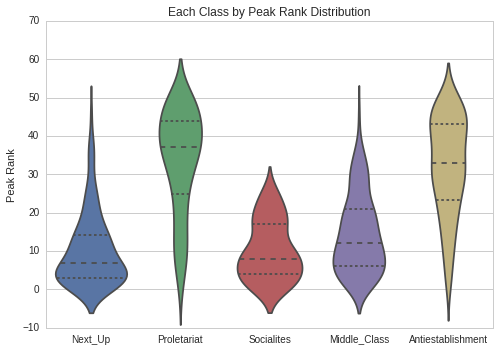

In [125]:
sb.violinplot(x='pca_labels_2', y= "Peak Rank", data = the_herd, inner='quartile')
plt.xlabel('')
plt.title("Each Class by Peak Rank Distribution")

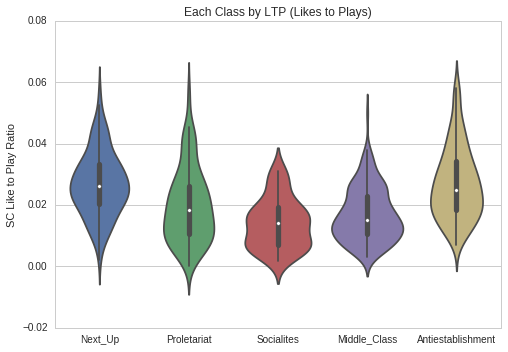

In [119]:
sb.violinplot(x='pca_labels_2', y= "SC Like to Play Ratio", data = the_herd)
plt.xlabel("")
plt.title("Each Class by LTP (Likes to Plays)")

One issue I'm rubbing up against is how seriously to interpret a track's ltp (likes to plays) as indicative of their success. As you can see above, the lowest ltp rating is in the Socialites group. Now, is this indicative of average song quality for this group? Or, as discussed previously, is this a byproduct of receiving more plays? Interpreting the graph above literally would have us believe that our Proletariat group is producing better quality tracks than both our Socialites group and our Middle Class. As someone who has listened through many tracks in each sub-group, I can assure you this is objectively not the case. The issue here is that our Proletariat group is averaging far fewer plays than any other group, a track with 300 plays and 30 likes is receiving an ltp of 0.1 which is astronomically higher than the average. This behavior is exhibited in many observations of the Proletariat group. It's clear we're going to have to come up with a better way of scoring our tracks.

## Section B

One thing we are confident in is that if two tracks both receive a similar and sufficient amount of plays, say > 100k, we are comfortable comparing their ltp. What gets tricky is comparing tracks with lower amount of plays to those with significantly higher plays. This is where the difference in ltp diverges drastically. After fiddling with an algorithm based on Bayesian Estimation, I've come up with something that I think works in balancing out these differences and appropriately scores track "success". 

To start, I will include not only ltp but also a metric of reposts to plays (rtp). This seems reasonable to include and perhaps even more indicative of song success since reposting is a share and continuation in the chain of acquiring more plays. Liking a track doesn't provide the same branching out behavior. 

Now for both of these two metrics I will derive an overall score based on how confident we are that we are observing a track's true ltp and rtp. The more plays a track has, the more confident we are in the observed metrics. The less plays a track has, the less confident we are in the observed metrics. Basically our algorithm is adjusting for this confidence variability in an intelligent way. After we will combine both metric scores to receive an overall song score that rates tracks on (hopefully) quality/health.

I also flirted with the idea of favorably bumping the scores of tracks with very high number of plays, but ultimately decided against it. My reasoning, it's valuable knowledge in terms of a track's health to note if a track is getting more plays than it's quality can sustain. If you're getting multiple plays from the same listeners over and over again and as a byproduct receiving lower ltp and rtp, I would argue this is a strike against the track's health. Ideally we would like to observe the best tracks maintaining high ltp and rtp in conjunction with the highest amount of plays possible. This would satisfy the idea that the track is consistently expanding into new groups of listeners who are actively engaging with it.

And so... our algorithm:

In [132]:
# Variables
c = np.percentile(h_sc.loc[(h_sc["pca_labels"] == "The_Herd") & (h_sc["sc_plays"] < 37018), "sc_plays"], 50)
r_m = h_sc.loc[h_sc["pca_labels"] == "Royalty", "SC Repost to Play Ratio"].mean()
r_l = h_sc.loc[h_sc["pca_labels"] == "Royalty", "SC Like to Play Ratio"].mean()

# Algorithm
score_ltp = (h_sc["sc_plays"]/(c + h_sc["sc_plays"]))*h_sc["SC Like to Play Ratio"] + \
                                                     (c/(c + h_sc["sc_plays"]))*r_l
score_rtp = (h_sc["sc_plays"]/(c + h_sc["sc_plays"]))*h_sc["SC Repost to Play Ratio"] + \
                                                     (c/(c + h_sc["sc_plays"]))*r_m

# Combining the scores
h_sc["song_score"] = 0.65*score_rtp + 0.35*score_ltp

Let's take a peak at our top 50, tracked Jan to March on Hype Machine, according to our scoring algorithm:

In [137]:
for i in h_sc["song_score"].nlargest(50).index:
    print(str(hype_m.loc[i,"Artist"]) + " - " + str(hype_m.loc[i,"Soundcloud Link"]))

mura masa - https://soundcloud.com/swindail/lotus-eater-swindail-remix
Tennyson x Mr. Carmack - https://soundcloud.com/redbullsoundselect/tennyson-x-mr-carmack-tuesday
Soul II Soul - https://soundcloud.com/zikomo/soul-ii-soul-back-to-life-zikomo-remix-1
GoldLink - https://soundcloud.com/goldlink/meditation
sam gellaitry - https://soundcloud.com/samgellaitry/jungle-waters
LANY - https://soundcloud.com/andrewlucemusic/lany-ilysb-andrew-luce-remix
Smino - https://soundcloud.com/sminoworld/anita
REZZ X K?D - https://soundcloud.com/official-rezz/rezz-x-kid-fourth-impact
ZHU - https://soundcloud.com/zhu/nightcrawler
DJ BORING - https://soundcloud.com/djboring1990/winona
SNBRN & BLU J - https://soundcloud.com/snbrn/snbrn-blu-j-you-got-me-feat-cara-frew
Mura Masa - https://soundcloud.com/muramasamusic/1-night
ZHU x MIGOS - https://soundcloud.com/zhu/zhu-x-migos-bad-and-boujee
Flume - https://soundcloud.com/flume/flume-depth-charge
MICK JENKINS - https://soundcloud.com/mickjenkins/pressed-for-t

Of course quality will always be subjective. The tracks above span a variety of tastes, genres, and moods. One could argue over order for hours, but our algorithm does an excellent job of identifying those tracks which are received well with a preference towards higher played tracks. I'll create Spotify and SoundCloud playlists of the top 100 for those interested in hearing the best scoring tracks.

### Analysis on Scores

[To-do]
.
.
.



# Step 4: Modeling
...

# Looking Forward
Disclaimer at the end - Something to look for in the future, tracks it seems will re-emerge months later after catching a new wave of hype, will need to collect more data for next time and cover a wider length of time. On to Spotify!